# ИМПОРТЫ

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
! pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
import pickle
from pickle import load
import joblib
! pip install scikit-multilearn
from skmultilearn.model_selection import iterative_train_test_split 
from sklearn.utils import shuffle

import warnings 
warnings.filterwarnings("ignore")

# Проект по определению упаковочного материала для доставки заказа.

**Общее описание задачи:**

Для того, чтобы пользователь получил
заказ, необходимо упаковать заказанные товары в посылки конечному клиенту.
Компания заметила, что сотрудник тратит большое количество времени для
выбора упаковочного материала в который необходимо упаковать товары.
Существует большое количество упаковочного материала (коробочки,
пакетики). Необходимо придумать способ подсказывать пользователю
информацию о выборе упаковочного материала

**Цель машинного обучения:**

– С высокой точностью рекомендовать правильную упаковку для заказа,
которая позволит доставить товары без порчи клиенту и минимизирует затраты
на упаковочный материал.

**План работы над проектом:**

- загрузить данные, представленные заказчиком и изучить их
- выявить закономерности, влияющие на выбор упаковки
- изучить данные об упаковках
- сгенирировать целевой признак на основе имеющейся информации
- разделить выборки на тестовую и обучающую
- обучить модель
- исследовать мерики качества 

In [2]:
# Установка опции для отображения всех столбцов
pd.set_option('display.max_columns', None)
# Установить максимальную ширину столбца
pd.set_option('display.max_colwidth', None)

# ЗАГРУЗКА ДАННЫХ

In [3]:
carton = pd.read_csv('carton.csv')
data = pd.read_csv('data.csv')
sku_cargotypes = pd.read_csv('sku_cargotypes.csv')
sku = pd.read_csv('sku.csv')
cargotype_info = pd.read_csv('cargotype_info.csv')

## Датасет со сведениями о заказах

Посмотрим на данные в датасете data (сведения о заказах):

In [4]:
data.head()

,Unnamed: 0,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
0,0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
1,1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
2,2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
3,3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
4,4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24


Удалим все лишние столбцы:

In [5]:
data = data.drop(['Unnamed: 0', 'whs', 'selected_cartontype', 'box_num', 'recommended_cartontype', 'sel_calc_cube', 'rec_calc_cube', 
                  'who', 'trackingid', 'pack_volume'], axis=1)

In [6]:
data.head()

,orderkey,selected_carton,recommended_carton,goods_wght,sku
0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd
1,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd
2,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd
3,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd
4,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd


В таблице представлены свеения об уникальном номере заказа - orderkey, сведения об упаковке, выбранной пользователем - selected_carton, сведения об упаковке, рекомендованной программой - recommended_carton, вес единицы товара - goods_wght, индивидуальный номер товара - sku.

## Датасет со сведениями о товарах

Посмотрим на сведения о товарах:

In [7]:
sku.head()

,Unnamed: 0,sku,a,b,c
0,0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,31.0,28.0
1,1,d9af6ce6f9e303f4b1a8cb47cde21975,29.0,14.0,40.0
2,2,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0
3,3,e8af308a7659e34194770d1e3a48e144,3.0,13.0,8.0
4,4,dc0e2542e122731217289b8e6d3bd3f8,96.0,18.0,56.0


Здесь мы видим габариты товара. Следовательно, эти данные нам нужны для вычесления объема заказа, присоединим эти размеры к таблице data:

In [8]:
df = data.merge(sku, how='inner', on = 'sku')

In [9]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
df.head()

,orderkey,selected_carton,recommended_carton,goods_wght,sku,a,b,c
0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0
1,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0
2,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0
3,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0
4,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0


Сведения о размерах получены. Можно добавить новый признак - объем заказа:

In [11]:
df['volume_sku'] = df['a']*df['b']*df['c']

## Датасет с информацией об упаковке

In [12]:
carton

,CARTONTYPE,LENGTH,WIDTH,HEIGHT,DISPLAYRFPACK
0,YMA,24.7,15.0,10.00,1
1,YMC,30.0,20.0,15.00,1
2,YME,30.0,30.0,44.50,1
3,YMF,35.0,25.0,15.00,1
4,YMG,44.7,30.0,20.00,1
5,YMH,42.0,20.0,86.00,0
6,YMJ,50.0,29.0,48.00,0
7,KSD,0.0,0.0,0.00,0
8,YML,60.0,40.0,45.00,1
9,YMN,60.0,60.0,40.00,0


В этом датасете мы видим размеры имеющихся упаковок. Определим их объем:

In [13]:
carton['carton_volume'] = carton['LENGTH']*carton['WIDTH']*carton['HEIGHT']

## Генерация новых признаков

Посчитаем количество каждого товара в заказе:

In [14]:
df['count_sku'] = df.groupby(['orderkey', 'sku'])['sku'].transform('count')

Посчитаем количество уникальных товаров в заказе:

In [15]:
df['item_count'] = df.groupby('orderkey')['sku'].transform('nunique')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314830 entries, 0 to 314829
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   orderkey            314830 non-null  object 
 1   selected_carton     314830 non-null  object 
 2   recommended_carton  314830 non-null  object 
 3   goods_wght          314830 non-null  float64
 4   sku                 314830 non-null  object 
 5   a                   314830 non-null  float64
 6   b                   314830 non-null  float64
 7   c                   314830 non-null  float64
 8   volume_sku          314830 non-null  float64
 9   count_sku           314830 non-null  int64  
 10  item_count          314830 non-null  int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 28.8+ MB


Для анализа посчитаем сколько коробок используется для одного заказа:

In [18]:
df['unique_count_sel_carton'] = df.groupby('orderkey')['selected_carton'].transform('nunique')

In [19]:
df['unique_count_rec_carton'] = df.groupby('orderkey')['recommended_carton'].transform('nunique')

In [20]:
df.head()

,orderkey,selected_carton,recommended_carton,goods_wght,sku,a,b,c,volume_sku,count_sku,item_count,unique_count_sel_carton,unique_count_rec_carton
0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1
1,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1
2,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1
3,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1
4,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1


Еще посчитаем общий объем одинаковых товаров в заказе (зная их размеры и количество):

In [21]:
df['total_volume_sku'] = df['volume_sku']*df['count_sku']

А также суммарный вес товаров, относящихся к оному индефикатору sku:

In [22]:
df['total_wght'] = df['goods_wght']*df['count_sku']

Проверим, что признаки добавлены:

In [25]:
df.head()

,orderkey,selected_carton,recommended_carton,goods_wght,sku,a,b,c,volume_sku,count_sku,item_count,unique_count_sel_carton,unique_count_rec_carton,total_volume_sku,total_wght
0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1,34782.0,1.7
1,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1,34782.0,1.7
2,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1,34782.0,1.7
3,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1,34782.0,1.7
4,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1,34782.0,1.7


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314830 entries, 0 to 314829
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   orderkey                 314830 non-null  object 
 1   selected_carton          314830 non-null  object 
 2   recommended_carton       314830 non-null  object 
 3   goods_wght               314830 non-null  float64
 4   sku                      314830 non-null  object 
 5   a                        314830 non-null  float64
 6   b                        314830 non-null  float64
 7   c                        314830 non-null  float64
 8   volume_sku               314830 non-null  float64
 9   count_sku                314830 non-null  int64  
 10  item_count               314830 non-null  int64  
 11  unique_count_sel_carton  314830 non-null  int64  
 12  unique_count_rec_carton  314830 non-null  int64  
 13  total_volume_sku         314830 non-null  float64
 14  tota

Мы добавили новые признаки в датасет, в частности объем и вес товаров в заказе с одинаковыми id, сколько всего уникальных товаров в заказе, сколько использовано упаковок при сборке заказа. 

# АНАЛИЗ ДАННЫХ:

Статистическая отчетность:

In [27]:
df.describe()

,goods_wght,a,b,c,volume_sku,count_sku,item_count,unique_count_sel_carton,unique_count_rec_carton,total_volume_sku,total_wght
count,314830.000000,314830.000000,314830.000000,314830.000000,3.148300e+05,314830.000000,314830.000000,314830.000000,314830.000000,3.148300e+05,314830.000000
mean,0.880027,17.953635,11.421650,14.502609,3.826418e+03,5.295410,3.692558,1.076562,1.134053,1.756114e+04,2.344092
std,2.320041,16.557085,9.864142,10.717607,1.269858e+04,21.306973,10.326571,0.303515,0.453801,1.415237e+05,8.625307
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000
25%,0.110000,8.800000,4.700000,7.100000,5.000000e+02,1.000000,1.000000,1.000000,1.000000,7.526400e+02,0.200000
50%,0.300000,14.000000,8.600000,11.000000,1.197000e+03,1.000000,1.000000,1.000000,1.000000,2.210000e+03,0.538000
75%,0.750000,21.500000,16.000000,19.000000,3.071788e+03,3.000000,3.000000,1.000000,1.000000,6.996395e+03,1.600000
max,88.000000,257.000000,240.000000,200.000000,1.680000e+06,257.000000,163.000000,5.000000,6.000000,3.677520e+06,382.200000


Как видим из статистических данных, у нас много выбросов, от которых нужно почистить датасет перед обучением. Визуализируем эти выбросы:

In [28]:
# Выбираем только числовые столбцы
numeric_columns = ['goods_wght', 'a', 'b', 'c', 'volume_sku', 'count_sku', 'item_count','unique_count_sel_carton', 
                   'unique_count_rec_carton', 'total_volume_sku', 'total_wght']

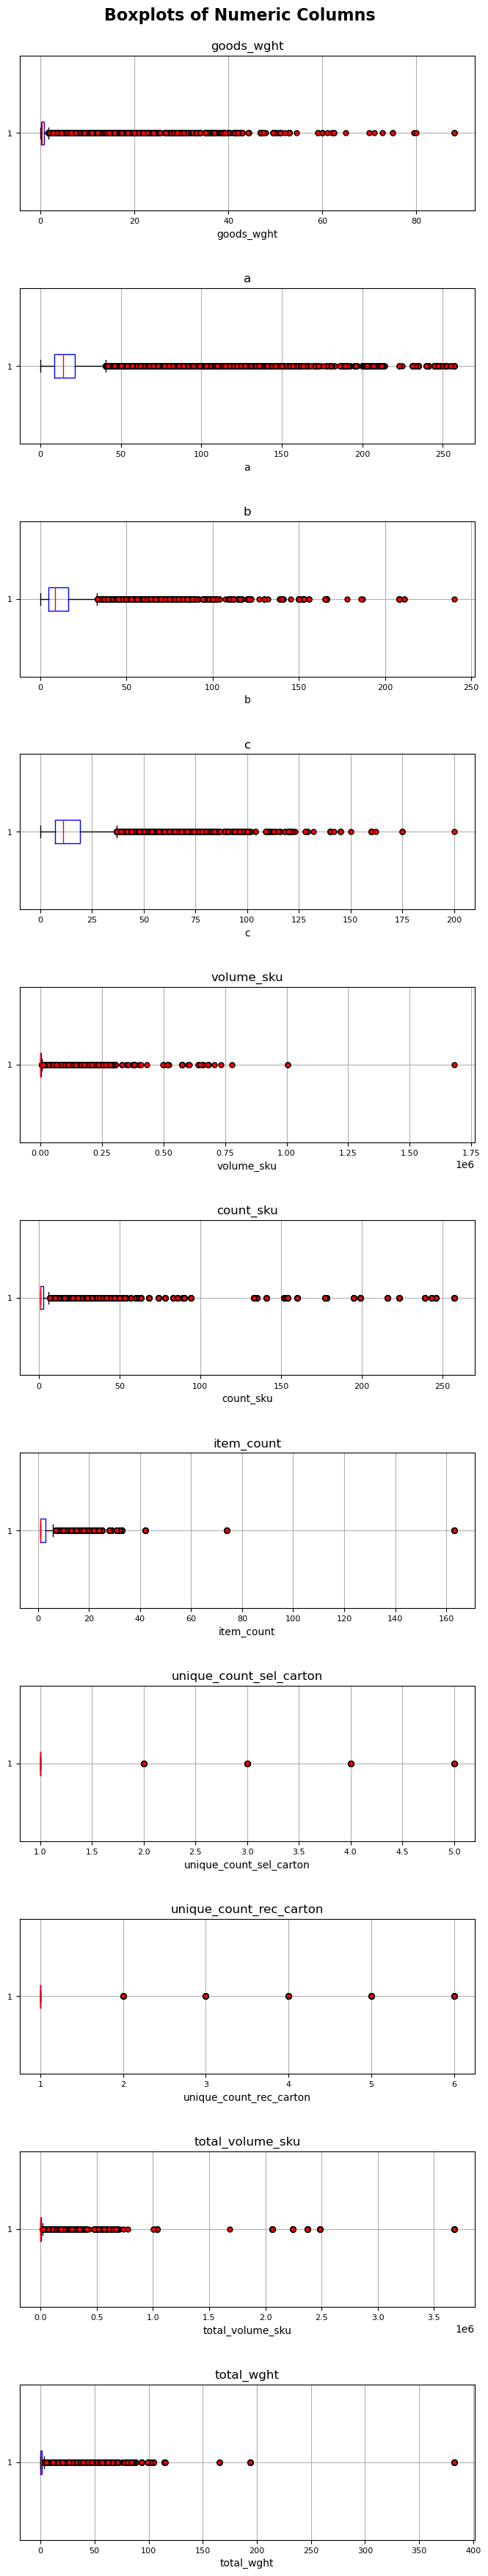

In [29]:
# Создаем подграфики с индивидуальными осями
fig, axes = plt.subplots(nrows=len(numeric_columns), figsize=(8, 4*len(numeric_columns)), sharex=False)

# Настройка внешнего вида графиков
boxprops = dict(color='blue')  # Цвет боксов
whiskerprops = dict(color='black')  # Цвет усов
flierprops = dict(marker='o', markersize=5, markerfacecolor='red')  # Внешний вид выбросов
medianprops = dict(color='red')  # Цвет медианы

# Строим боксплоты для каждого числового столбца
for i, column in enumerate(numeric_columns):
    axes[i].boxplot(df[column], vert=False, boxprops=boxprops, whiskerprops=whiskerprops, flierprops=flierprops, medianprops=medianprops)
    axes[i].set_title(column, fontsize=12)
    axes[i].set_xlabel(column, fontsize=10)
    axes[i].grid(True)  # Добавляем сетку
    axes[i].tick_params(axis='both', labelsize=8)  # Изменяем размер шрифта меток

# Добавляем общий заголовок
plt.suptitle("Boxplots of Numeric Columns", fontsize=16, fontweight='bold', y=0.895)

# Увеличиваем расстояние между графиками
plt.subplots_adjust(hspace=0.5)

plt.show()

Удалим заказы весом более 400, 1000 - это уже аномалия, а также вес = 0. Далее удалим строки с количеством уникальных товаров более 25 штук, а также заказы с 23 миллионным объемом упаковки. Условия фильтрации:

In [30]:
df_filtered = df[df['item_count'] <= 25]

In [31]:
df_filtered = df_filtered[(0 < df_filtered['goods_wght']) & (df_filtered['goods_wght'] <= 75)]

In [32]:
df_filtered = df_filtered[df_filtered['count_sku'] <= 50]

In [33]:
df_filtered = df_filtered[df_filtered['volume_sku'] <= 300000]

In [34]:
df_filtered = df_filtered[df_filtered['total_volume_sku'] <= 400000]

In [35]:
df_filtered = df_filtered[df_filtered['total_wght'] <= 100]

Посмотрим на результат:

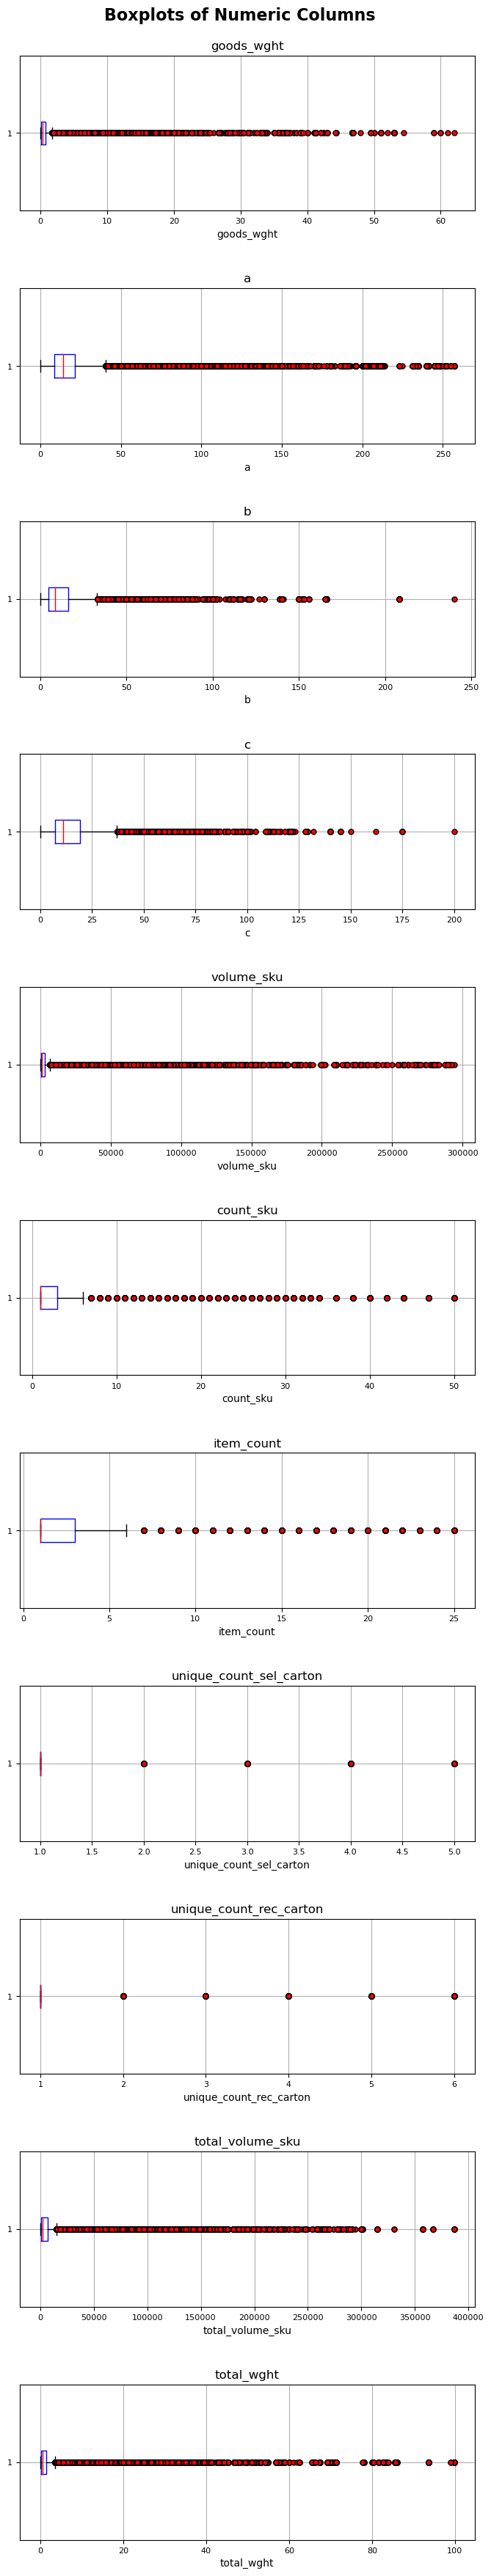

In [36]:
# Создаем подграфики с индивидуальными осями
fig, axes = plt.subplots(nrows=len(numeric_columns), figsize=(8, 4*len(numeric_columns)), sharex=False)

# Настройка внешнего вида графиков
boxprops = dict(color='blue')  # Цвет боксов
whiskerprops = dict(color='black')  # Цвет усов
flierprops = dict(marker='o', markersize=5, markerfacecolor='red')  # Внешний вид выбросов
medianprops = dict(color='red')  # Цвет медианы

# Строим боксплоты для каждого числового столбца
for i, column in enumerate(numeric_columns):
    axes[i].boxplot(df_filtered[column], vert=False, boxprops=boxprops, whiskerprops=whiskerprops, flierprops=flierprops, medianprops=medianprops)
    axes[i].set_title(column, fontsize=12)
    axes[i].set_xlabel(column, fontsize=10)
    axes[i].grid(True)  # Добавляем сетку
    axes[i].tick_params(axis='both', labelsize=8)  # Изменяем размер шрифта меток

# Добавляем общий заголовок
plt.suptitle("Boxplots of Numeric Columns", fontsize=16, fontweight='bold', y=0.895)

# Увеличиваем расстояние между графиками
plt.subplots_adjust(hspace=0.5)

plt.show()

Выбросов стало намного меньше, посмотрим как уменьшился объем с данными:

In [37]:
len(df_filtered)/len(df)*100

97.94746371057396

Удалили данных менее 3% процентов данных.

Теперь проанализируем, почему в заказе бывает больше одной упаковки:

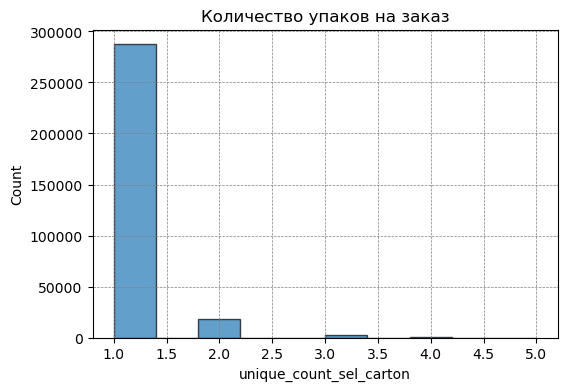

In [38]:
# Создание гистограммы
plt.figure(figsize=(6, 4))  
plt.hist(df_filtered['unique_count_sel_carton'], bins=10, edgecolor='black', alpha=0.7)

# Настройка осей и меток
plt.xlabel('unique_count_sel_carton')
plt.ylabel('Count')
plt.title('Количество упаков на заказ')

# Добавление сетки
plt.grid(color='gray', linestyle='dashed', linewidth=0.5)

# Отображение гистограммы
plt.show()


В основном для всех заказов используется одна упаковка, это также можно заметить при анализе boxplots, визуализированных выше. Можно заметить, что все значения превышающие одну упаковку на весь заказ находятся в зоне выбросов.

Необходимо понять, что повлияло на выбор более одной упаковки. Для этого можно построить тепловую карту и посмотреть, что повлияло на признаки unique_count_sel_carton и unique_count_rec_carton:

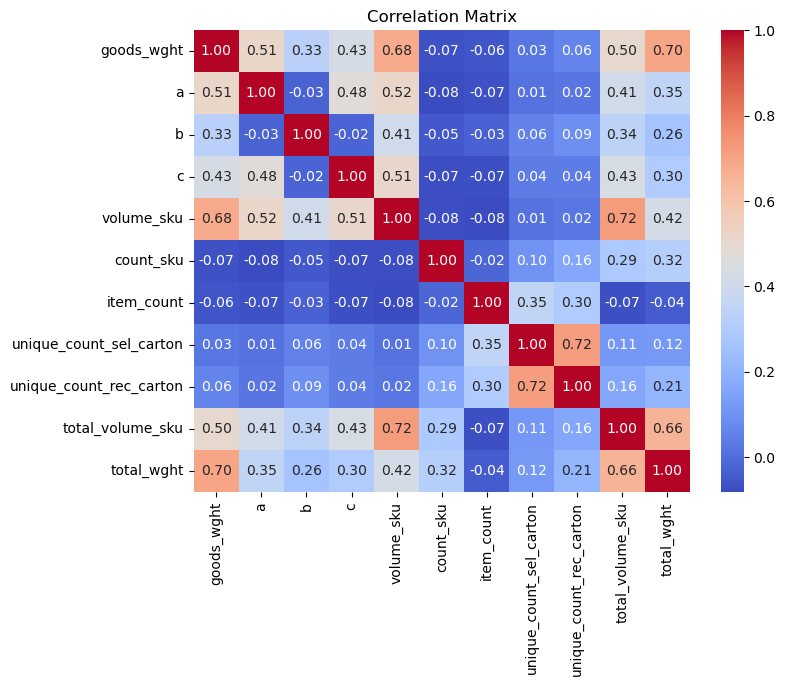

In [39]:
# Построение корреляционной матрицы
corr_matrix = df_filtered[['goods_wght', 'a', 'b', 'c', 'volume_sku', 'count_sku', 'item_count',	'unique_count_sel_carton',
	'unique_count_rec_carton', 'total_volume_sku', 'total_wght']].corr()

# Создание тепловой карты корреляционной матрицы
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True,  cmap='coolwarm', annot_kws={'fontsize': 10}, fmt='.2f')
# Настройка осей и меток
plt.title('Correlation Matrix')

# Отображение корреляционной матрицы
plt.show()

На графике видно, что абсолютно никакой линейной зависимости от количества упаков, выбранных пользователем, и признаками в датасете нет. Возможно все дело в других характеристиках товаров. А вот в выборе упаковки системой важным фактором является количество уникальных товаров item_count. Так же мы видим, что объем и вес имеют положительную зависимость, то есть чем больше объем товаров, тем, скорее всего, и больше его вес.

# КАРГОТИПЫ

Посмотрим как описание товаров влияет на комплектацию заказа:

In [40]:
sku_cargotypes_info = sku_cargotypes.merge(cargotype_info, how='inner', on = 'cargotype')

Получили таблицу, где есть индивидуальный номер товара, его карготип и описание этого карготипа:

In [41]:
sku_cargotypes_info

,Unnamed: 0_x,sku,cargotype,Unnamed: 0_y,description
0,0,4862bf0e760a593b13f3f2fcf822e533,290,66,Склад МГТ (малогабаритный товар)
1,2,50d3c4fc66ad423b7feaadff2d682ee0,290,66,Склад МГТ (малогабаритный товар)
2,4,24ce9dba9f301ada55f60e25ee1498d2,290,66,Склад МГТ (малогабаритный товар)
3,7,54a4f25859c817c131b7ec620d1ff278,290,66,Склад МГТ (малогабаритный товар)
4,10,5b94613996d27ce2c3d9ad983f612a37,290,66,Склад МГТ (малогабаритный товар)
...,...,...,...,...,...
21040531,20458931,5065f4f18789386b9b4b596da12a807c,752,51,ультра-фреш
21040532,20458936,346a8c7a6475b6c9c4bb21b0c6c3b07b,752,51,ультра-фреш
21040533,6385244,cf717bb204ad07bd8f22176af8962766,1300,95,большой аксессуар
21040534,13088139,4410f900221a92b8b18697010094db34,1300,95,большой аксессуар


Для одного товара существует несколько карготипов, объединим их в списки:

In [42]:
# Группировка по столбцу "sku" и объединение значений в список
sku_cargotypes_group = sku_cargotypes_info.groupby('sku').agg({'cargotype': list, 'description': list}).reset_index()

# Оставление только уникальных значений "sku"
sku_cargotypes_group[['sku']].drop_duplicates(inplace=True)

Получили таблицу:

In [43]:
sku_cargotypes_group.head()

,sku,cargotype,description
0,0000060b72e5a5d67ee3c37ceab6b72a,"[290, 950, 671]","[Склад МГТ (малогабаритный товар), пачкается, детские игрушки и игры]"
1,00000c9eb5ba2364380ab2e3bf870c23,"[290, 441, 480, 440, 460, 690]","[Склад МГТ (малогабаритный товар), товары для красоты, химикаты, косметика и парфюмерия, пахучий, цена низкая]"
2,000010b2dda4921d4982818e241847bf,"[290, 441, 490, 480, 440, 690]","[Склад МГТ (малогабаритный товар), товары для красоты, средства личной гигиены, химикаты, косметика и парфюмерия, цена низкая]"
3,00001196fe633174323cb69c4ad05ecb,[290],[Склад МГТ (малогабаритный товар)]
4,000015d94c63b8dbac214ad23bb8bb20,"[290, 200, 310]","[Склад МГТ (малогабаритный товар), техника и электроника, хрупкое]"


## Объединение сведений о карготипах с основным датасетом.

Теперь, когда нам известны карготипы, объединим их с нашим отфильтрованным датасетом:

In [44]:
df_new = df_filtered.merge(sku_cargotypes_group, how='inner', on='sku')

Разберем один заказ, в котором использовано 4 упаковки:

In [45]:
df_new[df_new['orderkey'] == '04b874853fdb97170d4c2e5657952c97']

,orderkey,selected_carton,recommended_carton,goods_wght,sku,a,b,c,volume_sku,count_sku,item_count,unique_count_sel_carton,unique_count_rec_carton,total_volume_sku,total_wght,cargotype,description
5144,04b874853fdb97170d4c2e5657952c97,YME,YME,0.910,e1b22c4655a72f069d8860680766e222,43.0,10.0,22.0,9460.000,3,11,4,4,28380.000,2.730,"[290, 340]","[Склад МГТ (малогабаритный товар), не требует упаковки]"
5145,04b874853fdb97170d4c2e5657952c97,YME,YME,0.910,e1b22c4655a72f069d8860680766e222,43.0,10.0,22.0,9460.000,3,11,4,4,28380.000,2.730,"[290, 340]","[Склад МГТ (малогабаритный товар), не требует упаковки]"
5146,04b874853fdb97170d4c2e5657952c97,YME,YME,0.910,e1b22c4655a72f069d8860680766e222,43.0,10.0,22.0,9460.000,3,11,4,4,28380.000,2.730,"[290, 340]","[Склад МГТ (малогабаритный товар), не требует упаковки]"
21147,04b874853fdb97170d4c2e5657952c97,YMG,YMX,0.148,d5995c8ef527ee7915660c12e48661af,10.4,10.3,9.9,1060.488,2,11,4,4,2120.976,0.296,"[290, 340]","[Склад МГТ (малогабаритный товар), не требует упаковки]"
21149,04b874853fdb97170d4c2e5657952c97,YMG,YMX,0.148,d5995c8ef527ee7915660c12e48661af,10.4,10.3,9.9,1060.488,2,11,4,4,2120.976,0.296,"[290, 340]","[Склад МГТ (малогабаритный товар), не требует упаковки]"
70164,04b874853fdb97170d4c2e5657952c97,NONPACK,YML,0.450,f5d57756a2dc5675dc50b61a31e27a22,17.0,14.0,14.0,3332.000,1,11,4,4,3332.000,0.450,"[290, 340]","[Склад МГТ (малогабаритный товар), не требует упаковки]"
228768,04b874853fdb97170d4c2e5657952c97,YMW,YMA,0.057,da0d22229dd2e5958b5b09cccddc76ee,13.0,9.0,8.0,936.000,1,11,4,4,936.000,0.057,[290],[Склад МГТ (малогабаритный товар)]
228961,04b874853fdb97170d4c2e5657952c97,YMG,YML,0.793,9555e3bf39beb19b5c7599febd01fc83,13.7,22.4,12.5,3836.000,1,11,4,4,3836.000,0.793,"[290, 200, 960]","[Склад МГТ (малогабаритный товар), техника и электроника, мнется]"
229178,04b874853fdb97170d4c2e5657952c97,YMG,YMX,0.426,5648ed9d29cde78ae3ffc0411c7d3494,26.0,4.0,18.0,1872.000,4,11,4,4,7488.000,1.704,[290],[Склад МГТ (малогабаритный товар)]
229179,04b874853fdb97170d4c2e5657952c97,YMG,YMX,0.426,5648ed9d29cde78ae3ffc0411c7d3494,26.0,4.0,18.0,1872.000,4,11,4,4,7488.000,1.704,[290],[Склад МГТ (малогабаритный товар)]


Общий объем заказа - 65649, на складе есть коробки, куда бы поместились все товары, из описания мы видим, что все товары малогабаритны, один из товаров мнется, но именно он положен в коробку с YMG, в которую чаще других упаковывались товары в заказе, а не в отдельную упаковку или пленку. Из этого можно сделать вывод, что все товары можно было упаковать в одну подходящую упаковку. Будем отталкиваться от этого принципа, что все товары в заказе должны поместится в одну упаковку. Отфильтруем это условие:

In [46]:
df_new = df_new[df_new['unique_count_sel_carton'] == 1]

In [47]:
df_new = df_new[df_new['unique_count_rec_carton'] == 1]

## Установление признаков с учетом карготипов товаров

Так как у нас очень много карготипов и они повторяются, создадим наиболее часто встречаемые признаки на их основе, а сами списки с описанием и кодом удалим:

In [48]:
# Добавляем столбецы с признаками из 'description'
df_new[['упаковка в пленку', 'не требует упаковки', 'сыпучее', 'пачкает', 'готовое блюда', 'хрупкое', 'интим товар',
        'цена высокая', 'пахучий', 'мнется', 'цена низкая', 'опасный', 'электроника',
        'цена средняя', 'товары для авто и мототехники', 'впитывает запах', 'продукты питания',
        'средства личной гигиены', 'товары для животных',
        'химикаты', 'аптека', 'одежда, обувь, аксессуары', 'меркурий', 'прочие']] = df_new['description'].apply(
    lambda x: pd.Series([1 if 'упаковка в пленку' in x else 0,
                         1 if 'не требует упаковки' in x else 0,
                         1 if 'сыпучее' in x else 0,
                         1 if 'пачкает' in x else 0,
                         1 if 'готовое блюда' in x else 0,
                         1 if 'хрупкое' in x else 0,
                         1 if 'интим товар' in x else 0,
                         1 if 'цена высокая' in x else 0,
                         1 if 'пахучий' in x else 0,
                         1 if 'мнется' in x else 0,
                         1 if 'цена низкая' in x else 0,
                         1 if 'опасный' in x else 0,
                         1 if 'электроника' in x else 0,
                         1 if 'цена средняя' in x else 0,
                         1 if 'товары для авто и мототехники' in x else 0,
                         1 if 'впитывает запах' in x else 0, 
                         1 if 'продукты питания' in x else 0,
                         1 if 'средства личной гигиены' in x else 0,
                         1 if 'товары для животных' in x else 0,
                         1 if 'химикаты' in x else 0,
                         1 if 'аптека' in x else 0,
                         1 if 'одежда, обувь, аксессуары' in x else 0,
                         1 if 'меркурий' in x else 0,
                         1 if not any(val in x for val in ['упаковка в пленку', 'не требует упаковки', 'сыпучее', 'пачкает', 'готовое блюда', 'хрупкое', 'интим товар',
                                                          'цена высокая', 'пахучий', 'мнется', 'цена низкая', 'опасный', 'электроника',
                                                          'цена средняя', 'товары для авто и мототехники', 'впитывает запах', 'продукты питания',
                                                          'средства личной гигиены', 'товары для животных',
                                                          'химикаты', 'аптека', 'одежда, обувь, аксессуары', 'меркурий']) else 0])) 



Посмотрим, как распредилился товар по признакам:

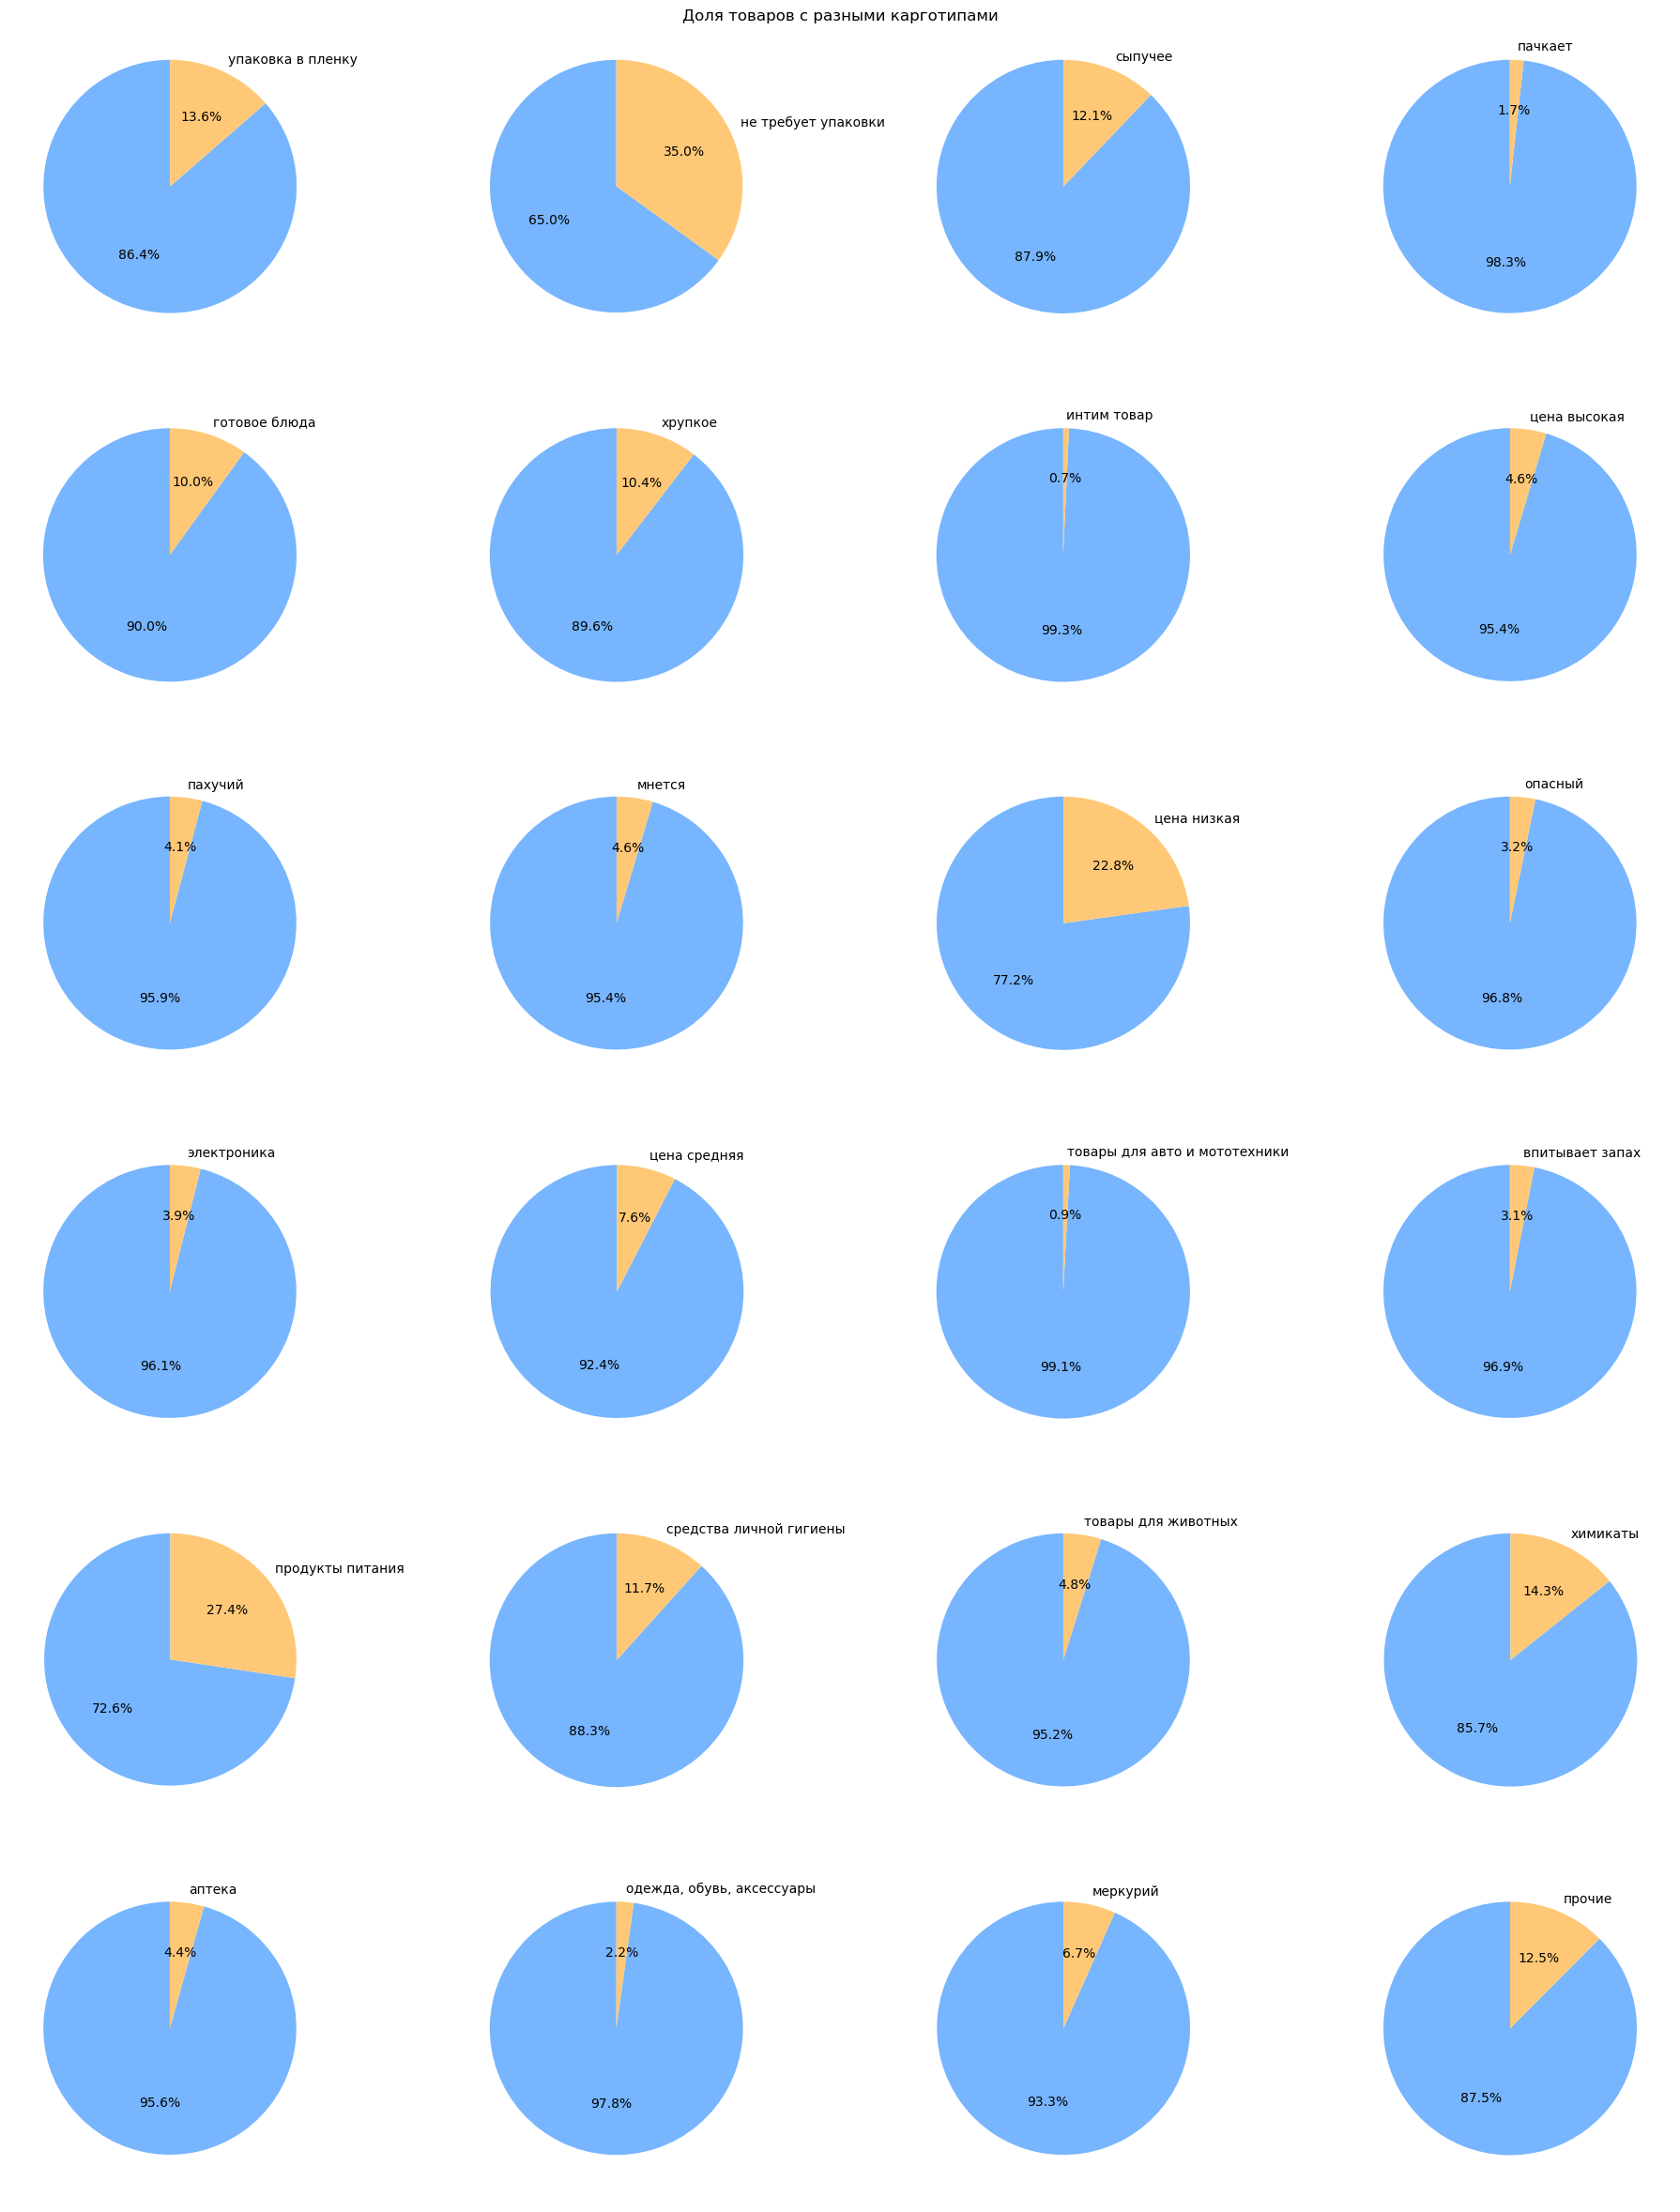

In [49]:
columns = ['упаковка в пленку', 'не требует упаковки', 'сыпучее', 'пачкает', 'готовое блюда', 'хрупкое', 'интим товар',
           'цена высокая', 'пахучий', 'мнется', 'цена низкая', 'опасный', 'электроника', 'цена средняя',
           'товары для авто и мототехники', 'впитывает запах', 'продукты питания', 'средства личной гигиены',
           'товары для животных', 'химикаты', 'аптека', 'одежда, обувь, аксессуары', 'меркурий', 'прочие']

# Разбиваем столбцы на группы по 4
groups = [columns[i:i+4] for i in range(0, len(columns), 4)]

# Создание сетки графиков
fig, axes = plt.subplots(len(groups), 4, figsize=(18, 4*len(groups)), tight_layout=True)

# Настройка параметров графиков в каждой группе
for i, group in enumerate(groups):
    for j, column in enumerate(group):
        ax = axes[i, j]
        value_counts = df_new[column].value_counts()
        counts = [value_counts[0], value_counts.get(1, 0)]
        labels = ['', column]
        ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#77B5FE', '#FFC877'])
        ax.axis('equal')

# Установка общего заголовка для всей фигуры
fig.suptitle('Доля товаров с разными карготипами')

# Отображение графиков
plt.show()

Доля товаров с выделенными признаками во всем датасете значительная, выделение других признаков пока не требуется. Удаляем данные в виде списков:

In [50]:
df_new.drop(['cargotype', 'description'], axis=1, inplace=True)

Посмотрим на итоговый датасет:

In [51]:
df_new.head()

,orderkey,selected_carton,recommended_carton,goods_wght,sku,a,b,c,volume_sku,count_sku,item_count,unique_count_sel_carton,unique_count_rec_carton,total_volume_sku,total_wght,упаковка в пленку,не требует упаковки,сыпучее,пачкает,готовое блюда,хрупкое,интим товар,цена высокая,пахучий,мнется,цена низкая,опасный,электроника,цена средняя,товары для авто и мототехники,впитывает запах,продукты питания,средства личной гигиены,товары для животных,химикаты,аптека,"одежда, обувь, аксессуары",меркурий,прочие
0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1,34782.0,1.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1,34782.0,1.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1,34782.0,1.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1,34782.0,1.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1,34782.0,1.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


# Промежуточное решение проблемы

Перед тем как построить модель, предсказывающую общую упаковку для всего заказа, распределим упаковку для каждого отдельного товара на основе цикла. Нельзя не учитывать, что у нас есть товары с меткой - опасное, и перевозить их с готовым блюдом не совсем правильно, также у нас есть интим-товары, которые в общем заказе желательно запоковать отдельно, есть хрупкие вещи, которые если едут например со строительными материалами, и также требуют отдельной упаковки.

Для решения такой задачи для начала дадим всем безопасным товаром которые не требуют упаковки метку - nonpack:

In [52]:
df_nonpack = df_new[(df_new['интим товар'] == 0) & (df_new['химикаты'] == 0) & (df_new['хрупкое'] == 0) & (df_new['не требует упаковки'] == 1)
                     & (df_new['сыпучее'] == 0) & (df_new['пачкает'] == 0)&(df_new['упаковка в пленку'] == 0)&(df_new['пахучий'] == 0)
                     & (df_new['мнется'] == 0) & (df_new['опасный'] == 0) & (df_new['впитывает запах'] == 0)& (df_new['химикаты'] == 0)]

In [53]:
df_nonpack['box_name'] = 'NONPACK'

Теперь повторим похожую фильтрацию для товаров, которые рекомендовано завернуть в пленку:

In [54]:
df_strech = df_new[(df_new['интим товар'] == 0) & (df_new['химикаты'] == 0) & (df_new['хрупкое'] == 0) & (df_new['не требует упаковки'] == 0)
                     & (df_new['сыпучее'] == 0) & (df_new['пачкает'] == 0)&(df_new['упаковка в пленку'] == 1)&(df_new['пахучий'] == 0)
                     & (df_new['мнется'] == 0) & (df_new['опасный'] == 0) & (df_new['впитывает запах'] == 0)& (df_new['химикаты'] == 0)]

In [55]:
df_strech['box_name'] = 'STRETCH'

Объединим полученные датасеты с метками и отнимем их из общего датасета:

In [56]:
merged_df = pd.concat([df_nonpack, df_strech], ignore_index=True)

In [57]:
df_other = df_new.merge(merged_df, indicator=True, how='left').query('_merge == "left_only"').drop('_merge', axis=1)

Теперь, когда у нас есть датасет с товарами, которые желательно запоковать, мы подберем для них индивидуальную упаковку на основе общего объема всех аналогичных товаров и известных объемов упаковок:

In [58]:
# Создаем пустой список для хранения выбранных упаковок
selected_packs = []

# Итерируемся по строкам первого датасета
for index, row in df_other.iterrows():
    # Получаем объем товара для текущей строки
    total_volume = row['total_volume_sku']
    
    # Инициализируем переменные для выбранной упаковки и ее разницы в объеме
    selected_pack = None
    min_volume_diff = float('inf')
    
    # Итерируемся по упаковкам из второго датасета
    for pack_index, pack_row in carton.iterrows():
        # Получаем объем упаковки
        pack_volume = pack_row['carton_volume']
        
        # Вычисляем разницу в объеме между упаковкой и товаром
        volume_diff = pack_volume - total_volume
        
        # Проверяем, является ли текущая упаковка наиболее оптимальной
        if volume_diff >= 0 and volume_diff < min_volume_diff:
            min_volume_diff = volume_diff
            selected_pack = pack_row['CARTONTYPE']
    
    # Добавляем выбранную упаковку в список
    selected_packs.append(selected_pack)

# Добавляем столбец с выбранными упаковками в первый датасет
df_other['box_name'] = selected_packs

Снова выполним соединение всех датасетов и перемешаем все строки:

In [59]:
# Concatenate the datasets vertically
merged_df_new = pd.concat([merged_df, df_other], ignore_index=True)

# Shuffle the rows
shuffled_df = shuffle(merged_df_new).reset_index(drop=True)

In [60]:
shuffled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281135 entries, 0 to 281134
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   orderkey                       281135 non-null  object 
 1   selected_carton                281135 non-null  object 
 2   recommended_carton             281135 non-null  object 
 3   goods_wght                     281135 non-null  float64
 4   sku                            281135 non-null  object 
 5   a                              281135 non-null  float64
 6   b                              281135 non-null  float64
 7   c                              281135 non-null  float64
 8   volume_sku                     281135 non-null  float64
 9   count_sku                      281135 non-null  int64  
 10  item_count                     281135 non-null  int64  
 11  unique_count_sel_carton        281135 non-null  int64  
 12  unique_count_rec_carton       

Посмотрим, какие упаковки подобрались в результате:

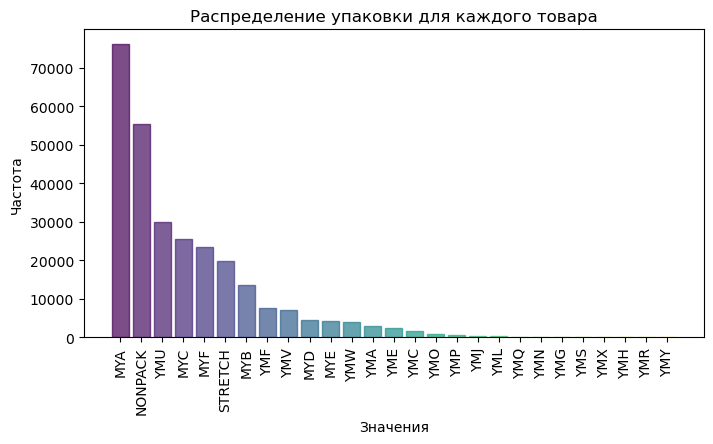

In [61]:
# Получение значения количества уникальных элементов упаковки
value_counts = shuffled_df['box_name'].value_counts()

# Создание градиента цветов
gradient = np.linspace(0, 1, len(value_counts))

# Создание графика
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(value_counts.index, value_counts, alpha=0.7, edgecolor='black')

# Настройка цветов столбцов
for bar, color in zip(bars, gradient):
    bar.set_color(plt.cm.viridis(color))

# Настройка осей и меток
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Распределение упаковки для каждого товара')
plt.xticks(rotation=90)

# Отображение графика
plt.show()

Самая распространенная упаковка - MYA, на втором месте NONPACK. Можно сделать дополнительные рекомендации для пользователя: если индивидуальная упаковка - NONPACK или STRETCH, а модель предложила упаковать товары, то в приоритет ставить рекомендацию по индивидуальной упаковки. Так же из этого графика можно сделать вывод, что чаще заказывают мелкие товары, так как MYA - самая маленькая упаковка, имеющаяся на складе, большие упаковки могут использоваться крайне редко.

# МОДЕЛИРОВАНИЕ

## Упаковка для заказа на основе выбора пользователя

У нас есть упаковка, выбранная пользователем, используем ее как целевой признак для предсказания упаковки:

In [62]:
df_new.head()

,orderkey,selected_carton,recommended_carton,goods_wght,sku,a,b,c,volume_sku,count_sku,item_count,unique_count_sel_carton,unique_count_rec_carton,total_volume_sku,total_wght,упаковка в пленку,не требует упаковки,сыпучее,пачкает,готовое блюда,хрупкое,интим товар,цена высокая,пахучий,мнется,цена низкая,опасный,электроника,цена средняя,товары для авто и мототехники,впитывает запах,продукты питания,средства личной гигиены,товары для животных,химикаты,аптека,"одежда, обувь, аксессуары",меркурий,прочие
0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1,34782.0,1.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1,34782.0,1.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1,34782.0,1.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1,34782.0,1.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,2046.0,17,3,1,1,34782.0,1.7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


Выполним объединение по столбцу orderkey:

In [63]:
df_agg = df_new.groupby('orderkey').agg({'selected_carton': lambda x: pd.Series.mode(x)[0],
    'goods_wght': ['min', 'max'],
    'a': ['mean', 'min', 'max'],
    'b': ['mean', 'min', 'max'],
    'c': ['mean', 'min', 'max'],
    'total_volume_sku': ['mean', 'min', 'max', 'sum'],
    'total_wght': 'max',	
    'volume_sku': ['mean', 'min', 'max'],
    'count_sku': 'mean',
    'item_count': 'mean',
    'упаковка в пленку': 'mean',
    'не требует упаковки': 'mean',
    'хрупкое': 'mean',
    'цена низкая': 'mean',
    'продукты питания': 'mean',
    'химикаты': 'mean'
})

# Flatten the column names
df_agg.columns = ['_'.join(col) for col in df_agg.columns]

df_agg = df_agg.reset_index()

In [64]:
df_agg.rename(columns={'selected_carton_<lambda>': 'selected_carton'}, inplace=True)

In [65]:
df_agg

,orderkey,selected_carton,goods_wght_min,goods_wght_max,a_mean,a_min,a_max,b_mean,b_min,b_max,c_mean,c_min,c_max,total_volume_sku_mean,total_volume_sku_min,total_volume_sku_max,total_volume_sku_sum,total_wght_max,volume_sku_mean,volume_sku_min,volume_sku_max,count_sku_mean,item_count_mean,упаковка в пленку_mean,не требует упаковки_mean,хрупкое_mean,цена низкая_mean,продукты питания_mean,химикаты_mean
0,00004fc4755eeb7e851e52ec91130fe4,MYC,1.000,1.000,17.0,17.0,17.0,38.0,38.0,38.0,6.0,6.0,6.0,3876.000,3876.000,3876.000,3876.000,1.000,3876.000,3876.000,3876.000,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,00008e765c2d85abfa9c97563afd98ef,MYB,0.135,0.135,19.0,19.0,19.0,3.0,3.0,3.0,5.0,5.0,5.0,285.000,285.000,285.000,285.000,0.135,285.000,285.000,285.000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0000c268eb1be1dd5b8c1a032f7318fc,MYC,0.090,0.090,25.0,25.0,25.0,7.0,7.0,7.0,17.0,17.0,17.0,8925.000,8925.000,8925.000,26775.000,0.270,2975.000,2975.000,2975.000,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0000fc4c7acac6e89f82392b90e47a27,MYB,0.200,0.200,7.0,6.0,8.0,6.0,6.0,6.0,17.5,13.0,22.0,708.000,624.000,792.000,1416.000,0.200,708.000,624.000,792.000,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0001963724fa4cc12d4f025056085633,YMW,0.200,0.256,12.0,10.0,15.0,14.0,12.0,17.0,8.0,5.0,10.0,6360.000,5100.000,7200.000,63600.000,1.200,1230.000,1200.000,1275.000,5.2,2.0,0.0,0.6,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147576,fffe13683b35336a4c1bb061f479f05b,MYA,0.016,0.016,9.0,9.0,9.0,1.5,1.5,1.5,9.0,9.0,9.0,121.500,121.500,121.500,121.500,0.016,121.500,121.500,121.500,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
147577,ffff1e5d7f5b52f28d733ba01a4589b9,MYC,0.150,0.150,25.0,25.0,25.0,3.0,3.0,3.0,14.0,14.0,14.0,1050.000,1050.000,1050.000,1050.000,0.150,1050.000,1050.000,1050.000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
147578,ffff1f0a51126b373f36d7733a5ddb0f,MYC,0.204,0.204,14.8,14.8,14.8,4.1,4.1,4.1,21.9,21.9,21.9,2657.784,2657.784,2657.784,5315.568,0.408,1328.892,1328.892,1328.892,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
147579,ffff748210310fffe23e3ade55d26401,MYA,0.030,0.030,5.0,5.0,5.0,6.0,6.0,6.0,4.0,4.0,4.0,120.000,120.000,120.000,120.000,0.030,120.000,120.000,120.000,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


Удаляем столбец orderkey:

In [66]:
df_agg.drop('orderkey', axis=1, inplace=True)

In [67]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147581 entries, 0 to 147580
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   selected_carton           147581 non-null  object 
 1   goods_wght_min            147581 non-null  float64
 2   goods_wght_max            147581 non-null  float64
 3   a_mean                    147581 non-null  float64
 4   a_min                     147581 non-null  float64
 5   a_max                     147581 non-null  float64
 6   b_mean                    147581 non-null  float64
 7   b_min                     147581 non-null  float64
 8   b_max                     147581 non-null  float64
 9   c_mean                    147581 non-null  float64
 10  c_min                     147581 non-null  float64
 11  c_max                     147581 non-null  float64
 12  total_volume_sku_mean     147581 non-null  float64
 13  total_volume_sku_min      147581 non-null  f

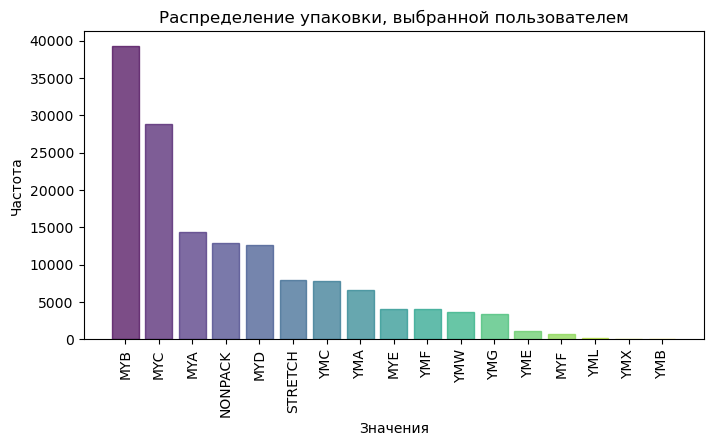

In [68]:
# Получение значения количества уникальных элементов упаковки
value_counts = df_agg['selected_carton'].value_counts()

# Создание градиента цветов
gradient = np.linspace(0, 1, len(value_counts))

# Создание графика
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(value_counts.index, value_counts, alpha=0.7, edgecolor='black')

# Настройка цветов столбцов
for bar, color in zip(bars, gradient):
    bar.set_color(plt.cm.viridis(color))

# Настройка осей и меток
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Распределение упаковки, выбранной пользователем')
plt.xticks(rotation=90)

# Отображение графика
plt.show()

Удалим упаковки, которые практически не использовались:

In [69]:
df_agg.selected_carton.unique()

array(['MYC', 'MYB', 'YMW', 'MYA', 'YME', 'MYE', 'MYD', 'NONPACK',
       'STRETCH', 'YMF', 'YMG', 'YMA', 'YMC', 'MYF', 'YMX', 'YML', 'YMB'],
      dtype=object)

In [70]:
df_agg = df_agg[~df_agg['selected_carton'].isin(['YMX', 'YML', 'YMB'])]

### Обучение

Разделяем данные на целевой признак и фичи:

In [71]:
X = df_agg.drop('selected_carton', axis=1).reset_index(drop=True)
y = df_agg['selected_carton']

Проводим кодировку и разделение выборки на обучающую и тестовую:

In [72]:
encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
y_encoded = encoder.fit_transform(y.values.reshape(-1,1))
X_train, y_train, X_test, y_test = iterative_train_test_split(X.values, y_encoded, test_size=0.25)

Используемая модель:

In [73]:
item_model = CatBoostClassifier(
    iterations= 2000, # сколько деревьев в ансамбле
    learning_rate = 0.1394345210078686, #регурялизация бустинга
    early_stopping_rounds=20, #ограничение на обучение (в данном случае если 20 эпох подряд качество ухудшается модель перестает обучаться)
    loss_function='MultiClass',
    random_seed=42,
    depth = 5,
    l2_leaf_reg = 3.3457380467351436,
    border_count = 191,
    verbose=0 #если вербосс = 0, модель не будет выводить на экран процесс обучения 
)

Обучаем модель и делаем предсказание:

In [74]:
X_train, y_train, X_val, y_val = iterative_train_test_split(X_train, y_train, test_size=0.25)

In [75]:
item_model.fit(
    X_train, y_train, eval_set = (X_val, y_val))

In [76]:
y_pred_proba = item_model.predict_proba(X_test)

In [77]:
predicted_labels = np.argmax(y_pred_proba, axis=1)

Выполняем раскодировку целевого признака:

In [78]:
y_pred = encoder.inverse_transform(predicted_labels.reshape(-1, 1))

In [79]:
y_test = encoder.inverse_transform(y_test)

Посмотрим на основные метрики:

In [80]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df

,precision,recall,f1-score,support
MYA,0.575668,0.433277,0.494425,3582.000000
MYB,0.594104,0.707564,0.645889,9797.000000
MYC,0.497868,0.543910,0.519872,7299.000000
MYD,0.387732,0.445898,0.414786,3133.000000
MYE,0.276458,0.125490,0.172623,1020.000000
MYF,0.000000,0.000000,0.000000,184.000000
NONPACK,0.603899,0.731965,0.661794,3216.000000
STRETCH,0.392202,0.260010,0.312710,1973.000000
YMA,0.470333,0.196612,0.277304,1653.000000
YMC,0.404188,0.393677,0.398863,1961.000000


Для классов MYB, NONPACK и MYC наблюдается относительно высокий уровень точности (precision) и полноты (recall), что указывает на хорошую способность модели правильно классифицировать эти классы.

Классы MYE, MYF и YMF имеют низкие значения точности, полноты и F1-меры. Это может свидетельствовать о трудностях модели в правильной классификации этих классов.

Для классов YMC и MYD значения точности и полноты примерно равны, что указывает на сбалансированность модели в правильной классификации этих классов.

Классы YME, YMG и YMW имеют средние значения точности, полноты и F1-меры.

Общая точность модели (accuracy) составляет 51.8%, что означает, что модель правильно классифицирует около половины случаев.

Средние значения (macro avg) и взвешенные значения (weighted avg) для точности, полноты и F1-меры указывают на среднюю производительность модели по всем классам.

В целом, модель показывает относительно хорошие результаты в классификации классов MYB, NONPACK и MYC, но имеет трудности в классификации классов с низкими значениями точности и полноты. Возможно, требуется дополнительное обучение или использование других подходов для улучшения производительности модели для этих классов.

Так же посмотрим на важность признаков в обучении модели:

In [82]:
feature_names = X.columns.tolist()
feature_importance = item_model.feature_importances_

if len(feature_names) == len(feature_importance):
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
else:
    print("Error: Length mismatch between feature_names and feature_importance")

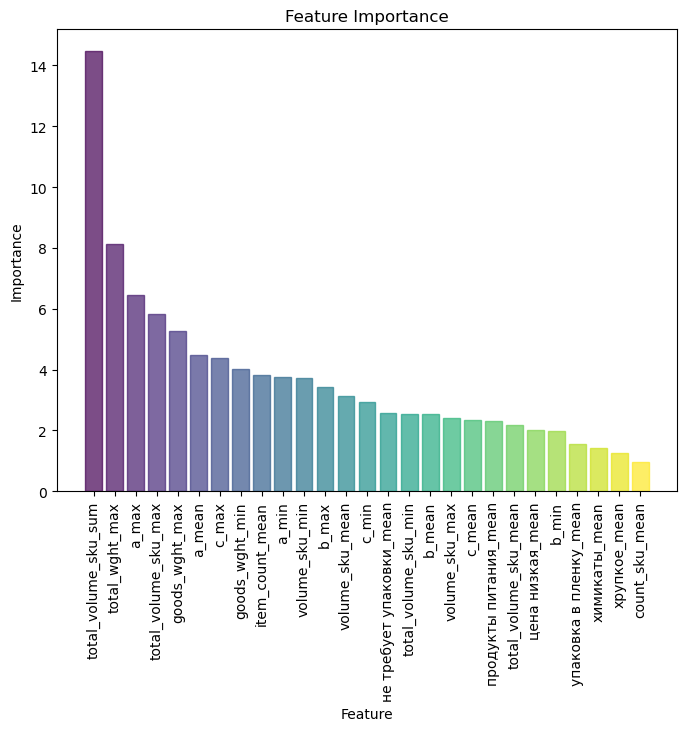

In [83]:
# Создание графика
plt.figure(figsize=(8, 6))
bars = plt.bar(importance_df['Feature'], importance_df['Importance'], alpha=0.7)

# Настройка цветов столбцов
colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Настройка осей и меток
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')

# Поворот меток по оси x, чтобы они были более читаемыми
plt.xticks(rotation=90)

# Отображение графика
plt.show()


Самым важным признаком для модели оказался общий объем заказа. Среди признаков не оказалось по настоящему значимых факторов, указывающих на выбор упаковки пользователем, об этом уже было сказано выше. 

In [84]:
# Сохранение модели в файл
with open("file_item.pcl", "wb") as fid:
    pickle.dump(item_model, fid)

In [85]:
# Сохранение кодировщика на диск
joblib.dump(encoder, 'encoder.pkl')

['C:/Users/user/Desktop/ТЕТРАДКИ/datasets/archive (1)/encoder.pkl']

# Упаковка на основе объема заказа

Поскольку модель правильно предсказывает только в половине случаев, стоит добавить дополнительную рекомендацию по упаковке заказа. У нас есть сведения об объеме упаковки, на основе цикла, который применялся в случае определения индивидуальной упаковки, воспользуемся им для предсказания упаковки для всего заказа:

In [86]:
df_agg.head()

,selected_carton,goods_wght_min,goods_wght_max,a_mean,a_min,a_max,b_mean,b_min,b_max,c_mean,c_min,c_max,total_volume_sku_mean,total_volume_sku_min,total_volume_sku_max,total_volume_sku_sum,total_wght_max,volume_sku_mean,volume_sku_min,volume_sku_max,count_sku_mean,item_count_mean,упаковка в пленку_mean,не требует упаковки_mean,хрупкое_mean,цена низкая_mean,продукты питания_mean,химикаты_mean
0,MYC,1.000,1.000,17.0,17.0,17.0,38.0,38.0,38.0,6.0,6.0,6.0,3876.0,3876.0,3876.0,3876.0,1.000,3876.0,3876.0,3876.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,MYB,0.135,0.135,19.0,19.0,19.0,3.0,3.0,3.0,5.0,5.0,5.0,285.0,285.0,285.0,285.0,0.135,285.0,285.0,285.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,MYC,0.090,0.090,25.0,25.0,25.0,7.0,7.0,7.0,17.0,17.0,17.0,8925.0,8925.0,8925.0,26775.0,0.270,2975.0,2975.0,2975.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,MYB,0.200,0.200,7.0,6.0,8.0,6.0,6.0,6.0,17.5,13.0,22.0,708.0,624.0,792.0,1416.0,0.200,708.0,624.0,792.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0
4,YMW,0.200,0.256,12.0,10.0,15.0,14.0,12.0,17.0,8.0,5.0,10.0,6360.0,5100.0,7200.0,63600.0,1.200,1230.0,1200.0,1275.0,5.2,2.0,0.0,0.6,0.0,0.0,1.0,0.0


In [87]:
# Создаем пустой список для хранения выбранных упаковок
selected_packs = []

# Итерируемся по строкам первого датасета
for index, row in df_agg.iterrows():
    # Получаем объем товара для текущей строки
    total_volume = row['total_volume_sku_sum']
    
    # Инициализируем переменные для выбранной упаковки и ее разницы в объеме
    selected_pack = None
    min_volume_diff = float('inf')
    
    # Итерируемся по упаковкам из второго датасета
    for pack_index, pack_row in carton.iterrows():
        # Получаем объем упаковки
        pack_volume = pack_row['carton_volume']
        
        # Вычисляем разницу в объеме между упаковкой и товаром
        volume_diff = pack_volume - total_volume
        
        # Проверяем, является ли текущая упаковка наиболее оптимальной
        if volume_diff >= 0 and volume_diff < min_volume_diff:
            min_volume_diff = volume_diff
            selected_pack = pack_row['CARTONTYPE']
    
    # Добавляем выбранную упаковку в список
    selected_packs.append(selected_pack)

# Добавляем столбец с выбранными упаковками в первый датасет
df_agg['box_name'] = selected_packs

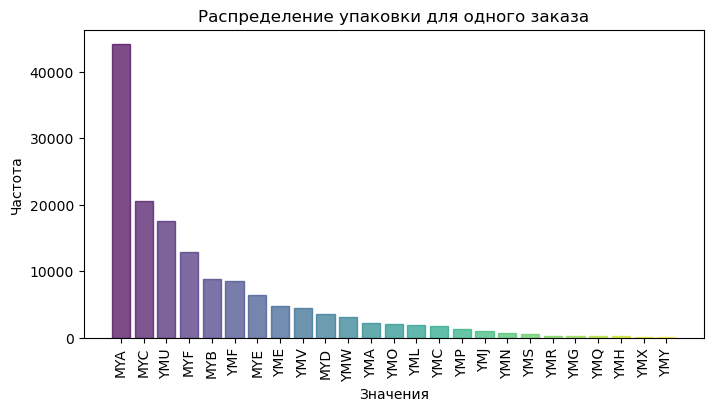

In [88]:
# Получение значения количества уникальных элементов упаковки
value_counts = df_agg['box_name'].value_counts()

# Создание градиента цветов
gradient = np.linspace(0, 1, len(value_counts))

# Создание графика
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(value_counts.index, value_counts, alpha=0.7, edgecolor='black')

# Настройка цветов столбцов
for bar, color in zip(bars, gradient):
    bar.set_color(plt.cm.viridis(color))

# Настройка осей и меток
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Распределение упаковки для одного заказа')
plt.xticks(rotation=90)

# Отображение графика
plt.show()

Упаковки, которые чаще всего выбирал пользователь - 'MYC', 'MYB', 'MYA', 'NONPACK', упаковки, которые максимально соответсвуют объему заказов - MYA, MYC, YMU, MYF, MYB. Выбор упаковки часто совпадает, вторую упаковку, выбранную на основе цикла можно рекомендовать как дополнительный выбор, пользователь может выбрать из двух упаковок наиболее подходящую.

# ОБЩИЙ ВЫВОД:

Проведен анализ представленных данных с целью исследования факторов, определяющих выбор упаковки пользователями. Однако, несмотря на проделанную работу, не удалось выявить явные закономерности или корреляции, которые бы объяснили предпочтения пользователей в отношении упаковки товаров. В результате, модель, разработанная на основе имеющихся данных, не проявила высокую производительность.

В связи с этим, было принято решение предоставить рекомендации пользователям, основываясь на объеме заказа и имеющихся вариантах упаковки. При анализе заказа рекомендуется учесть наличие опасных товаров и необходимость их разделения отдельной упаковкой. В случае, когда все товары могут быть помещены в одну упаковку, предпочтение отдается оптимальной по объему упаковке. В случае, если оптимальная упаковка не подходит для данного заказа, следует обратиться к рекомендации, предоставленной моделью.

Важно учесть, что данная рекомендация является дополнительной и может быть использована в случае отсутствия явных предпочтений пользователя или необходимости в оптимизации упаковки. В конечном итоге, выбор упаковки должен осуществляться с учетом конкретных требований заказа, приоритетов пользователя и возможных ограничений, связанных с безопасностью и защитой товаров.

Важно отметить, что дальнейшая работа над улучшением модели и анализом данных может потребовать более глубокого исследования факторов, влияющих на выбор упаковки, а также сбора дополнительных данных для повышения точности и надежности рекомендаций.